In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
feature_names= np.load(r'..\data\sklearn_toy_diabetes_feature_names.npy')
samp = pd.read_csv('samples_gp.csv')
cols = [i for i in samp.columns if i.startswith('rho[')]
length_scale_samples = samp[cols].to_numpy()

<IPython.core.display.Javascript object>


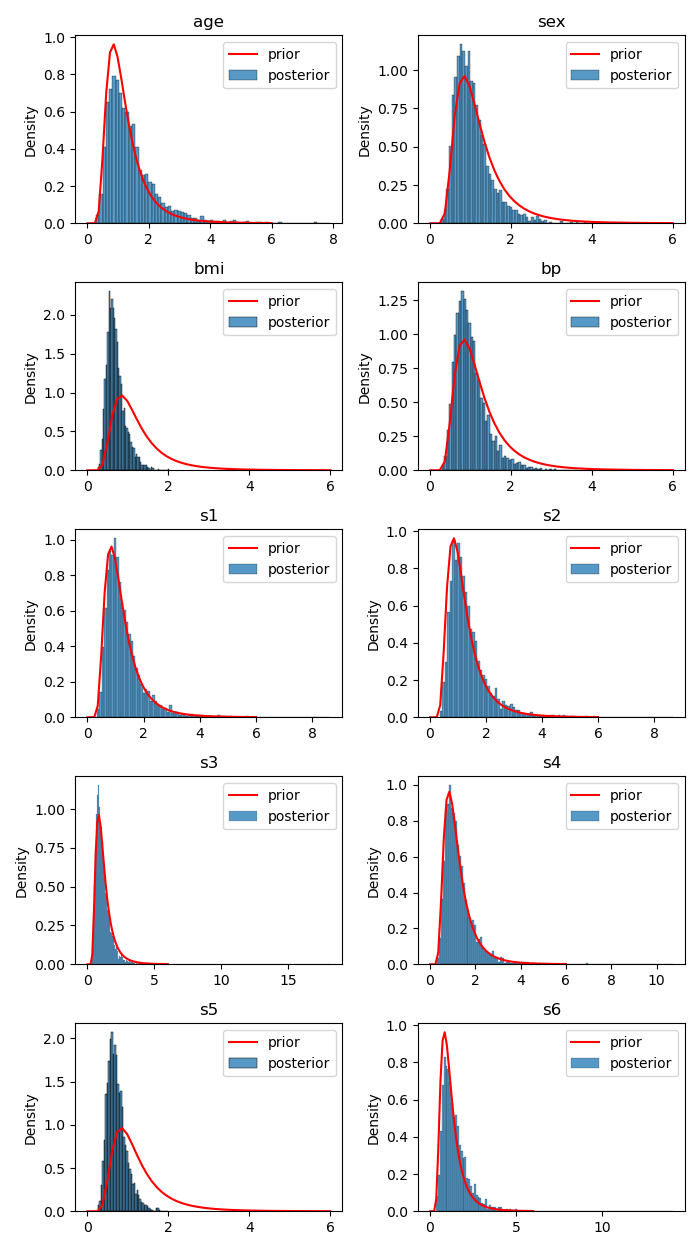

In [3]:
plt.close('all')
fig, ax= plt.subplots(5,2, figsize=(3.5*2, 2.5*5))
for i, feat_name in enumerate(feature_names):
    axrow= int(i/2)
    axcol= i % 2
    sns.histplot(data= length_scale_samples[:,i], stat='density', ax=ax[axrow, axcol], label='posterior')
    ax[axrow, axcol].set_title(feat_name)
    x1= np.linspace(0, 6, 50)
    ax[axrow, axcol].plot(x1, st.invgamma.pdf(x1, a= 5.0, scale= 5.0), 'r', label='prior')
    ax[axrow, axcol].legend()
plt.tight_layout()

In [4]:
from functools import reduce
from operator import concat
from sklearn import metrics as met

In [5]:
X_train= np.load(r'..\data\sklearn_toy_diabetes_Xtrain.npy')
y_train= np.load(r'..\data\sklearn_toy_diabetes_ytrain.npy')
X_test= np.load(r'..\data\sklearn_toy_diabetes_Xtest.npy')
y_test= np.load(r'..\data\sklearn_toy_diabetes_ytest.npy')

y_train_mean= np.load(r'..\data\y_train_mean.npy')
y_train_std= np.load(r'..\data\y_train_std.npy')

cols = [i for i in samp.columns if i.startswith('y2[')]
y_samples_sc = samp[cols].to_numpy().transpose() 
y_samples = (y_samples_sc * y_train_std ) + y_train_mean

In [6]:
y_q50= np.quantile(y_samples, 0.5,axis=1)
y_q1= np.quantile(y_samples, 0.1573 ,axis=1)
y_q3= np.quantile(y_samples, 0.8427 ,axis=1)
lower_err= y_q50 - y_q1
upper_err= y_q3 - y_q50

traintest= reduce(concat, [['train']*X_train.shape[0], ['test']*X_test.shape[0] ])
X = np.concatenate((X_train, X_test), axis=0)
df= pd.DataFrame(X, columns=feature_names)
y_sc = np.concatenate((y_train, y_test ), axis=0)
y= y_sc * y_train_std + y_train_mean
df['target']= y
df['traintest'] = traintest
df['yhat_q50']= y_q50
df['yhat_lower_err']= lower_err
df['yhat_upper_err']= upper_err
df['yhat_mean']= np.mean(y_samples, axis=1)
df['yhat_std']= np.std(y_samples, axis=1)
df.to_csv('yhat_stan.csv', index=False)

In [7]:
df_train= df.loc[df['traintest'] == 'train']
df_test= df.loc[df['traintest'] == 'test']

print('\nTrain set:')
print('\tRMSE: ',np.sqrt(met.mean_squared_error(df_train['target'], df_train['yhat_mean']) ) )
print('\nTest set:')
print('\tRMSE: ',np.sqrt(met.mean_squared_error(df_test['target'], df_test['yhat_mean']) ) )


Train set:
	RMSE:  54.71853566546665

Test set:
	RMSE:  50.86138308596593
